## Beta Bank Customer Churn Analysis

Overview:

Beta Bank customers are leaving: little by little, chipping away every month. The bankers figured out it’s cheaper to save the existing customers rather than to attract new ones.


We need to predict whether a customer will leave the bank soon. Use the data on clients’ past behavior and termination of contracts with the bank.


For this project I will build a model with the maximum possible F1 score. You need an F1 score of at least 0.59. Check the F1 for the test set.


Additionally, measure the AUC-ROC metric and compare it with the F1.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score, precision_score

In [3]:
data = pd.read_csv('/datasets/Churn.csv')

In [4]:
print(data.shape)
print(data.head(5))

(10000, 14)
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0     2.0       0.00              1          1               1   
1     1.0   83807.86              1          0               1   
2     8.0  159660.80              3          1               0   
3     1.0       0.00              2          0               0   
4     2.0  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4

10,000 observations

14 columns

Getting rid of observations with nulls and duplicate records.

In [5]:
data.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [6]:
data.duplicated().sum()

0

Missing Data Pattern: 
The Tenure feature had 909 missing values out of 10,000 observations (about 9%). This is a relatively small percentage that won't significantly impact your dataset size.

Feature Importance: 
Tenure (how long a customer has been with the bank) is likely an important predictor for churn. Customers with longer tenure might be less likely to leave. Rather than imputing potentially incorrect values, removing these records preserves data integrity.

In [7]:
data = data.dropna()

In [8]:
data.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [9]:
print(data.dtypes)

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object


## Feature Encoding

Let's use One Hot Encoding to transform categorical variables into numerical ones since there are no ordinal variables and we are not using a tree based algorithm.

I will also declare the target and feature variables and split the data.

In [10]:
data_ohe = pd.get_dummies(data, drop_first=True)
target = data_ohe['Exited']
features = data_ohe.drop(['Exited'], axis=1)

# Create a 3-way split
features_temp, features_test, target_temp, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345, stratify=target
)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_temp, target_temp, test_size=0.25, random_state=12345, stratify=target_temp
)

print(f"Train: {len(features_train)} samples")
print(f"Validation: {len(features_valid)} samples") 
print(f"Test: {len(features_test)} samples")


Train: 5454 samples
Validation: 1818 samples
Test: 1819 samples


## Checking Class Frequency/Balance

Let's check the class frequency without having balanced the classes. We can use this as a baseline for improving the model.

0    0.796062
1    0.203938
Name: Exited, dtype: float64


<AxesSubplot:>

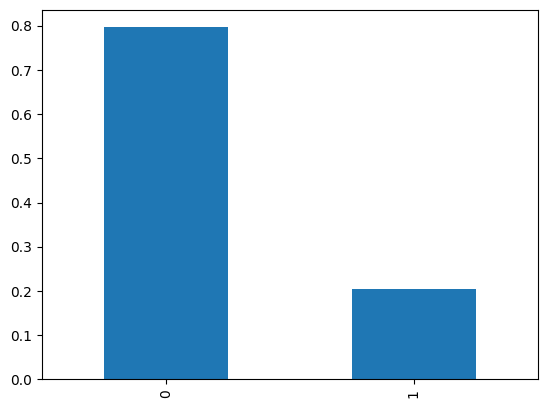

In [11]:
class_frequency = target.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

## Try LogisticRegression model as a baseline

Now we will train our model. I'm using Logistic Regression because this is a classification task and we are predicting classes.

In [39]:
model_lr = LogisticRegression(random_state = 12345, solver = 'liblinear')
model_lr.fit(features_train, target_train)

LogisticRegression(random_state=12345, solver='liblinear')

Now let's have the model make predictions (with imbalanced classes) and test it's accuracy.

In [40]:
predicted_valid = model_lr.predict(features_valid)
accuracy_valid = accuracy_score(target_valid, predicted_valid)
accuracy_valid

0.7959295929592959

The accuracy is the same as the class "0" frequency which means that the model is predicting "stay" for every customer and has 0% recall for churning customers - it's missing ALL 451 customers who will actually churn!

Let's calculate a confusion matrix as well as the precision and recall scores in order to calculate the F1 score which will balance precision and recall, giving a better measure of how well the model identifies the minority class (churning customers) compared to just accuracy.

In [14]:
cm = confusion_matrix(target_valid, predicted_valid)
print("Confusion matrix:\n", cm)

Confusion matrix:
 [[1447    0]
 [ 371    0]]


1822 samples correctly predicted as "stayed" (True Negatives)

0 samples incorrectly predicted as "churned" (False Positives)

451 samples incorrectly predicted as "stayed" (False Negatives)

0 samples correctly predicted as "churned" (True Positives)

The model has learned a very simple strategy: "Always predict that customers will stay"

With 80% of customers staying, the model can achieve 80% accuracy just by always guessing "no churn"


This baseline is extremely valuable because:

It shows the problem clearly.
Pure class imbalance effect
It gives a benchmark
Any balanced approach should beat this
It demonstrates why accuracy alone is misleading in imbalanced datasets

✅ Class distribution analysis - 79.6% vs 20.4%  
✅ Basic performance metrics - 80.1% accuracy  
✅ Confusion matrix analysis - Identified the "always predict 0" behavior  
✅ Precision/Recall/F1 - All 0 for positive class  

## Recall, Precision, F1

In [15]:
recall = recall_score(target_valid, predicted_valid)
precision = precision_score(target_valid, predicted_valid)
print('Recall: ', recall)
print('Precision: ', precision)

Recall:  0.0
Precision:  0.0


/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
f1 = f1_score(target_valid, predicted_valid)
f1

0.0

The error when pulling the recall and precision scores tells us that the model never predicts class 1 because:

0/anything -> undefined

Class imbalance: 80% stay vs 20% churn

Conservative threshold: Default 0.5 threshold, but max probability is only 0.35

Model strategy: Learned "always predict stay" gives 80% accuracy

Let's calculate the probabilities of the model predicting each class with the predict_proba() method.

In [45]:
predicted_proba_lr = model_lr.predict_proba(features_valid)[:, 1]  # Probabilities for class 1
print(f"Max probability for churn: {predicted_proba.max():.4f}")
print(f"Mean probability for churn: {predicted_proba.mean():.4f}")

Max probability for churn: 0.3476
Mean probability for churn: 0.2041


The Decision Threshold
Logistic regression uses a 0.5 threshold by default:
- If probability ≥ 0.5 → Predict "churn" (class 1)
- If probability < 0.5 → Predict "stay" (class 0)

Since the maximum probability is only 0.3517 (well below 0.5), the model never predicts churn.

What This Means:

The threshold is the problem

The model is being too conservative

Class imbalance effect:

The model learned that "staying" is much more common, so it's very hesitant to predict "churn"

This insight shows you have two paths to improve performance:
1. Address class imbalance (resampling techniques)
2. Adjust the decision threshold

## Class Weight Balance Parameter with LogisticRegression

In [46]:
model_balanced_lr = LogisticRegression(class_weight='balanced', random_state=12345, solver='liblinear')
model_balanced_lr.fit(features_train, target_train)
predicted_valid_balanced_lr = model_balanced_lr.predict(features_valid)
print('F1:', f1_score(target_valid, predicted_valid_balanced_lr))


F1: 0.49805447470817116


The F1 score improved but it's not yet 0.59 which is our goal. Let's utilize another class balancing method of adjusting the decision threshold.

First let's see what the probability range is.

In [47]:
# First, let's see the distribution of probabilities
predicted_proba_balanced_lr = model_balanced_lr.predict_proba(features_valid)[:, 1]
print(f"Min probability: {predicted_proba_balanced_lr.min():.4f}")
print(f"Max probability: {predicted_proba_balanced_lr.max():.4f}")
print(f"Mean probability: {predicted_proba_balanced_lr.mean():.4f}")

Min probability: 0.0690
Max probability: 0.9469
Mean probability: 0.4489


Based on these numbers the model...
- Can predict high churn risk (up to 96.58%)
- Has good separation between classes
- Mean around 0.45 suggests reasonable balance

I will iterate through new treshold values starting around the mean:
- The mean is 0.4479, so the default 0.5 threshold might be too high
- I will try thresholds around 0.3 to 0.6 or maybe broader such as 0.2 to 0.7

In [48]:
thresholds = np.arange(0.2, 0.7, 0.05)  # Start broader, then narrow down
for threshold in thresholds:
    predictions_lr = (predicted_proba_lr >= threshold).astype(int)
    f1 = f1_score(target_valid, predictions_lr)
    print(f"Threshold: {threshold:.2f}, F1: {f1:.4f}")

Threshold: 0.20, F1: 0.3674
Threshold: 0.25, F1: 0.1915
Threshold: 0.30, F1: 0.0417
Threshold: 0.35, F1: 0.0000
Threshold: 0.40, F1: 0.0000
Threshold: 0.45, F1: 0.0000
Threshold: 0.50, F1: 0.0000
Threshold: 0.55, F1: 0.0000
Threshold: 0.60, F1: 0.0000
Threshold: 0.65, F1: 0.0000


## Upsampling and Downsampling (still with LogisticRegression model)

I am not able to get a good F1 score with either the class balancing parameter nor with threshold tuning. I need to try another class balancing technique. Let's try upsampling the minority class.

Since the ratio of the classes is 4:1 i will repeat the minority class by 4.

In [22]:
from sklearn.utils import shuffle


def upsample(features, target, repeat):
    features_zeros = features_train[target_train == 0]
    features_ones = features_train[target_train == 1]
    target_zeros = target_train[target_train == 0]
    target_ones = target_train[target_train == 1]

    arg1 = pd.concat([features_zeros] + [features_ones] * repeat)
    arg2 = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        arg1, arg2, random_state=12345
    )

    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(
    features_train, target_train, 4
)

print(features_upsampled.shape)
print(target_upsampled.shape)



(8790, 2799)
(8790,)


In [23]:
model_upsampled = LogisticRegression(random_state=12345, solver='liblinear')
model_upsampled.fit(features_upsampled, target_upsampled)
predicted_valid_upsampled = model_upsampled.predict(features_valid)
print('F1:', f1_score(target_valid, predicted_valid_upsampled))

F1: 0.36820083682008364


That didn't improve the F1 score, let's try downsampling the majority class.

In [24]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)]
        + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )

    return features_downsampled, target_downsampled


features_downsampled, target_downsampled = downsample(
    features_train, target_train, 0.2
)

model_downsampled = LogisticRegression(random_state=12345, solver='liblinear')
model_downsampled.fit(features_downsampled, target_downsampled)
predicted_valid_downsampled = model_downsampled.predict(features_valid)


print('F1:', f1_score(target_valid, predicted_valid_downsampled))


F1: 0.3716349310571241


## Trying new model: RandomForestClassifier()

Ok so resampling did not help. Let's try a different model all together and tune the threshold as well as the hyperparameters n_estimators and max_depth. I one hot encoded the features so I need a model that I can safely use with this data. Let's try the RandomForestClassifier.

In [34]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import f1_score

# Define hyperparameter ranges
max_depths = [5, 10, 15, 20, None]
n_estimators_list = [50, 100, 200, 300]
thresholds = np.arange(0.3, 0.7, 0.05)

# Track best combination
best_overall_f1 = 0
best_params = {}
best_threshold_overall = 0

print("Testing hyperparameter combinations...")
print("-" * 60)

# Iterate through hyperparameters
for max_depth in max_depths:
    for n_estimators in n_estimators_list:
        
        # Train model with current hyperparameters
        model_rf = RandomForestClassifier(
            max_depth=max_depth,
            n_estimators=n_estimators,
            random_state=12345
        )
        model_rf.fit(features_train, target_train)
        
        # Get probability predictions
        predicted_proba = model_rf.predict_proba(features_valid)[:, 1]
        
        # Find best threshold for this model
        best_f1_for_model = 0
        best_threshold_for_model = 0
        
        for threshold in thresholds:
            predictions = (predicted_proba >= threshold).astype(int)
            f1 = f1_score(target_valid, predictions)
            
            if f1 > best_f1_for_model:
                best_f1_for_model = f1
                best_threshold_for_model = threshold
        
        # Check if this is the best combination overall
        if best_f1_for_model > best_overall_f1:
            best_overall_f1 = best_f1_for_model
            best_params = {
                'max_depth': max_depth,
                'n_estimators': n_estimators
            }
            best_threshold_overall = best_threshold_for_model
        
        # Print results for this combination
        print(f"max_depth={max_depth}, n_estimators={n_estimators}: "
              f"F1={best_f1_for_model:.4f} at threshold={best_threshold_for_model:.2f}")

print("-" * 60)
print(f"BEST COMBINATION:")
print(f"max_depth: {best_params['max_depth']}")
print(f"n_estimators: {best_params['n_estimators']}")
print(f"Best threshold: {best_threshold_overall:.2f}")
print(f"Best F1 score: {best_overall_f1:.4f}")

Testing hyperparameter combinations...
------------------------------------------------------------
max_depth=5, n_estimators=50: F1=0.0054 at threshold=0.30
max_depth=5, n_estimators=100: F1=0.0107 at threshold=0.30
max_depth=5, n_estimators=200: F1=0.0266 at threshold=0.30
max_depth=5, n_estimators=300: F1=0.0107 at threshold=0.30
max_depth=10, n_estimators=50: F1=0.1069 at threshold=0.30
max_depth=10, n_estimators=100: F1=0.1443 at threshold=0.30
max_depth=10, n_estimators=200: F1=0.1580 at threshold=0.30
max_depth=10, n_estimators=300: F1=0.1716 at threshold=0.30
max_depth=15, n_estimators=50: F1=0.3517 at threshold=0.30
max_depth=15, n_estimators=100: F1=0.3586 at threshold=0.30
max_depth=15, n_estimators=200: F1=0.3312 at threshold=0.30
max_depth=15, n_estimators=300: F1=0.3107 at threshold=0.30
max_depth=20, n_estimators=50: F1=0.4397 at threshold=0.30
max_depth=20, n_estimators=100: F1=0.4048 at threshold=0.30
max_depth=20, n_estimators=200: F1=0.4405 at threshold=0.30
max_dept

With the technique of treshold tuning alone with the RandomForestClassifier, our F1 score improved and surpasses 0.59. Let's try a second balancing technique, class_weight='balanced', separately now that we've found the optimal model.

BEST COMBINATION:
max_depth: None,
n_estimators: 50,
Best threshold: 0.30,
Best F1 score: 0.6039

## Testing Class Balancing Parameter with RandomForestClassifier()

In [49]:
model_balanced_rf = RandomForestClassifier(class_weight='balanced', n_estimators=50, max_depth=None, random_state=12345)
model_balanced_rf.fit(features_train, target_train)
predictions_balanced_rf = model_balanced_rf.predict(features_valid)  # Default threshold
f1_balanced = f1_score(target_valid, predictions_balanced_rf)
print(f"Class weight balanced only: F1 = {f1_balanced:.4f}")

Class weight balanced only: F1 = 0.4271


The F1 score decreased. Now we know that simply threshold tuning with the RandomForestClassifier model is sufficient for getting an ideal F1 score.

## ROC and AUC-ROC with RandomForestClassifier() model with tuned threshold and optimal hyperparameters

Now let's examine the AUC-ROC values.

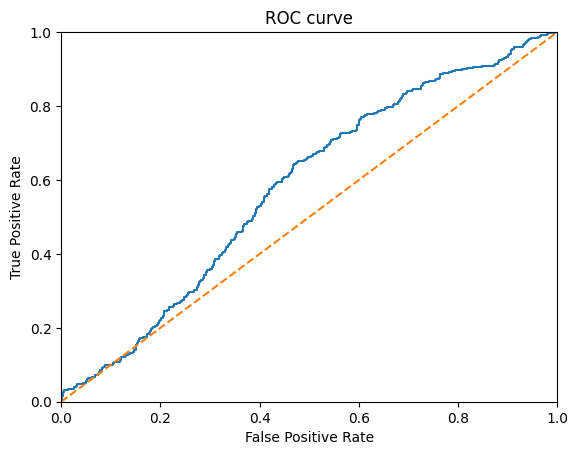

In [50]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(target_valid, predicted_proba)

plt.figure()

plt.plot(fpr, tpr)

# ROC curve for random model (a straight line)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

plt.show()


In [51]:
from sklearn.metrics import roc_auc_score
auc_roc = roc_auc_score(target_valid, predicted_proba)
print(auc_roc)

0.5805747368381836


## Testing Final Model

In [53]:

from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Train the final model with optimal hyperparameters
model_rf = RandomForestClassifier(
    max_depth=None,  # Replace with your best value
    n_estimators=50,  # Replace with your best value
    random_state=12345
)

# Fit on training data
model_rf.fit(features_train, target_train)

# Get probability predictions on test set
test_proba = model_rf.predict_proba(features_test)[:, 1]

# Apply threshold of 0.30
threshold = 0.30
test_predictions = (test_proba >= threshold).astype(int)

# Calculate F1 score
test_f1 = f1_score(target_test, test_predictions)

print(f"Final Model Performance on Test Set:")
print(f"Threshold: {threshold}")
print(f"F1 Score: {test_f1:.4f}")
print("\nClassification Report:")
print(classification_report(target_test, test_predictions))
print("\nConfusion Matrix:")
print(confusion_matrix(target_test, test_predictions))

Final Model Performance on Test Set:
Threshold: 0.3
F1 Score: 0.6118

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1448
           1       0.62      0.60      0.61       371

    accuracy                           0.84      1819
   macro avg       0.76      0.75      0.76      1819
weighted avg       0.84      0.84      0.84      1819


Confusion Matrix:
[[1313  135]
 [ 148  223]]


Now the model is ready to deploy and detect customers who are more likely to churn.

To recap, we found that the RandomForestClassifier with the right hyperparameters and treshold tuning gave us an optimal F1 score, aka an adequately harmonic mean between precision and recall.